In [2]:
import pandas as pd
import numpy as np

# plot libraries
import matplotlib.pyplot as plt
import seaborn as sns


!pip install openpyxl

In [3]:
excel_name = 'https://github.com/shionguha/inf1340-programmingfordatascience-fa22/raw/60b7f5d757553308a4b5db8c439c360ea244e07d/project%20data/UN_MigrantStockTotal_2015.xlsx'

In [34]:
# Additional information
annex = pd.read_excel(excel_name, sheet_name="ANNEX", header=14)
country_code_col = 'Country code'
major_col = 'Major area, region, country or area of destination'
major_areas = annex['Major area'].unique().tolist()
regions = annex['Region'].unique().tolist()
countries = annex[country_code_col].unique().tolist()

In [5]:
year_columns = [1990, 1995, 2000, 2005, 2010, 2015]
period_columns = ['1990-1995', '1995-2000', '2000-2005', '2005-2010', '2010-2015']

def update_one_table(table, sheet_title, gender, is_period=False, postfix=None):
    # rename country code column
    if not postfix:
        table.rename(columns={'Unnamed: 3': country_code_col, 'Unnamed: 1': major_col}, inplace=True)
    
    # define column names
    id_cols = [country_code_col, major_col]
    columns = period_columns if is_period else year_columns
    if postfix:
        columns = [str(col) + postfix for col in columns]
    table_gender = table[id_cols + columns]
    # Rename columns if necessary
    if postfix:
        new_columns = {col: col[:-len(postfix)] for col in columns}
        if not is_period:
            new_columns = {col: int(new_columns[col]) for col in new_columns}
        table_gender = table_gender.rename(columns=new_columns)
    # Move year to cells
    var_name = "period" if is_period else "year"
    table_gender = table_gender.melt(id_vars = id_cols, var_name = var_name, value_name = sheet_title)
    # Create a gender column and fill with both sexes
    table_gender['gender'] = gender
    # Replace .. with NaN and define the proper data types
    table_gender = table_gender.replace('..', np.nan) \
        .astype({
            var_name: 'string' if is_period else int,
            "gender": 'string',
            sheet_title: float,
            country_code_col: int,
            major_col: 'string'
        })
    
    return table_gender
    

def update_tables(table, sheet_title, is_period=False):
    table_both = update_one_table(table, sheet_title, 'both sexes', is_period)
    table_male = update_one_table(table, sheet_title, 'male', is_period, '.1')
    table_female = update_one_table(table, sheet_title, 'female', is_period, '.2')
    # concat the data for all genders
    table = pd.concat([table_both, table_male, table_female])
    return table

# Process Table 1

In [13]:
table1_col = 'International migrant stock at mid-year'
table = pd.read_excel(excel_name, sheet_name="Table 1", header=15)
table1 = update_tables(table, table1_col)
table1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4770 entries, 0 to 1589
Data columns (total 5 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Country code                                        4770 non-null   int32  
 1   Major area, region, country or area of destination  4770 non-null   string 
 2   year                                                4770 non-null   int32  
 3   International migrant stock at mid-year             4725 non-null   float64
 4   gender                                              4770 non-null   string 
dtypes: float64(1), int32(2), string(2)
memory usage: 186.3 KB


### Trend of immigrants by gender

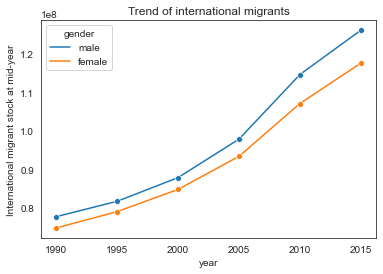

In [17]:
table1_1 = table1[table1['gender'] != 'both sexes']
table1_1 = table1_1[table1_1[country_code_col] == 900]
table1_1 = table1_1[["year", 'gender', table1_col]]
sns.set_style('white')
sns.lineplot(y=table1_col, x="year", hue = "gender", data=table1_1, marker='o')
plt.title('Trend of international migrants')
plt.show()

# Process Table 2

In [20]:
table2_col = 'Total population at mid-year'
table = pd.read_excel(excel_name, sheet_name="Table 2", header=15)
table2 = update_tables(table, table2_col)
table2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4770 entries, 0 to 1589
Data columns (total 5 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Country code                                        4770 non-null   int32  
 1   Major area, region, country or area of destination  4770 non-null   string 
 2   year                                                4770 non-null   int32  
 3   Total population at mid-year                        4386 non-null   float64
 4   gender                                              4770 non-null   string 
dtypes: float64(1), int32(2), string(2)
memory usage: 186.3 KB


### Distribution of population

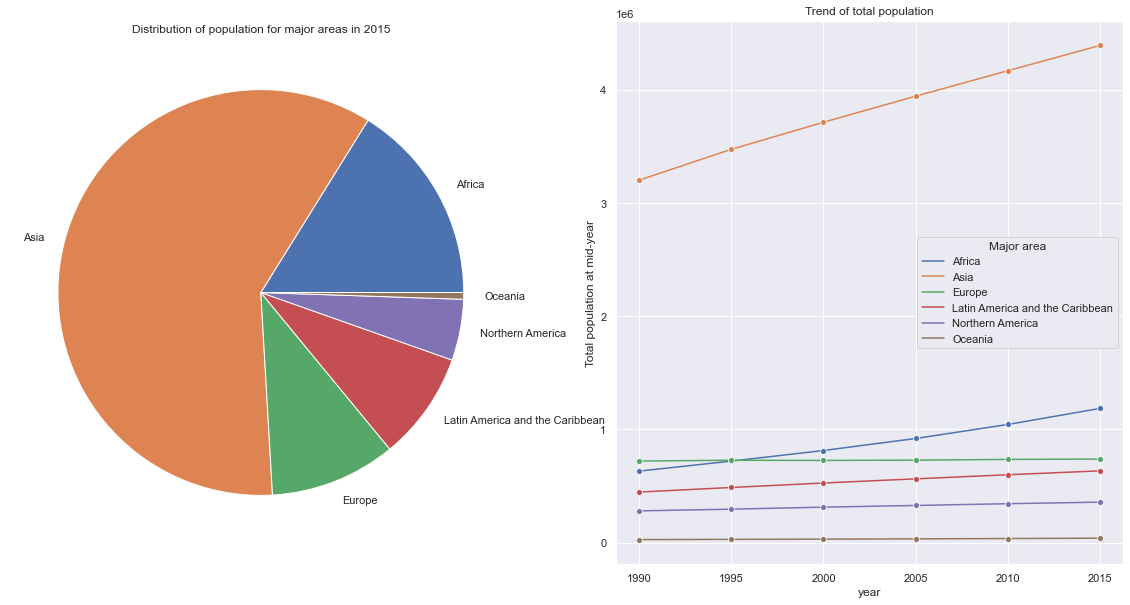

In [22]:
f, ax = plt.subplots(1, 2, figsize=(20,10))

table2_1 = table2[table2[major_col].isin(major_areas)]
table2_1 = table2_1[table2_1['gender'] == 'both sexes']
table2_1 = table2_1[table2_1['year'] == 2015]

ax[0].pie(table2_1[table2_col].values, labels=table2_1[major_col].values)
ax[0].title.set_text('Distribution of population for major areas in 2015')

table2_2 = table2[table2[major_col].isin(major_areas)]
table2_2 = table2_2[table2_2['gender'] == 'both sexes'][["year", major_col, table2_col]]
table2_2 = table2_2.rename(columns={major_col:'Major area'})
table2_2 = table2_2.groupby(["year", 'Major area']).sum()
sns.lineplot(y=table2_col, x="year", hue = 'Major area', data=table2_2, marker='o', ax=ax[1])
ax[1].title.set_text('Trend of total population')

plt.show()

# Process Table 3

In [24]:
table3_col = 'International migrant stock as a percentage of the total population'
table = pd.read_excel(excel_name, sheet_name="Table 3", header=15)
table3 = update_tables(table, table3_col)
table3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4770 entries, 0 to 1589
Data columns (total 5 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Country code                                                         4770 non-null   int32  
 1   Major area, region, country or area of destination                   4770 non-null   string 
 2   year                                                                 4770 non-null   int32  
 3   International migrant stock as a percentage of the total population  4343 non-null   float64
 4   gender                                                               4770 non-null   string 
dtypes: float64(1), int32(2), string(2)
memory usage: 186.3 KB


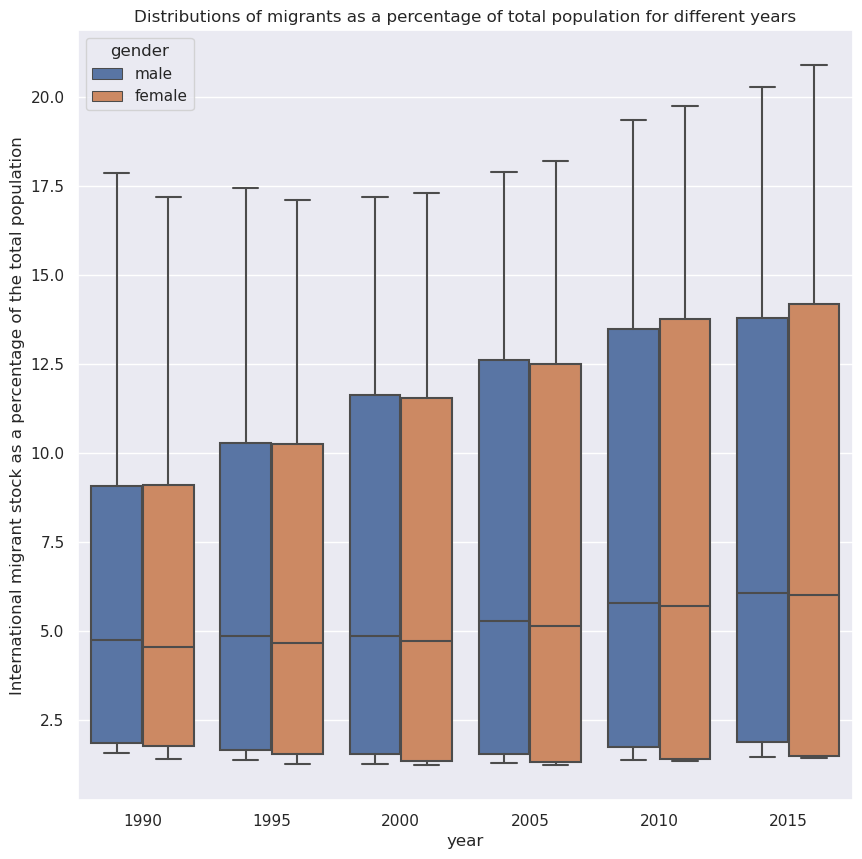

In [17]:
table3_1 = table3[table3['gender'] != 'both sexes']
table3_1 = table3_1[table3_1[major_col].isin(major_areas)]
sns.boxplot(y=table3_col, x="year", hue='gender', data=table3_1)
plt.title('Distributions of migrants as a percentage of total population for different years')
plt.show()

# Process Table 4

In [69]:
table4_col = 'Female migrants as a percentage of the international migrant stock'
table4 = pd.read_excel(excel_name, sheet_name='Table 4', header=15)
# Only female is needed, so call update_one_table
table4 = update_one_table(table4, table4_col, 'female')
table4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1590 entries, 0 to 1589
Data columns (total 5 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Country code                                                        1590 non-null   int32  
 1   Major area, region, country or area of destination                  1590 non-null   string 
 2   year                                                                1590 non-null   int32  
 3   Female migrants as a percentage of the international migrant stock  1575 non-null   float64
 4   gender                                                              1590 non-null   string 
dtypes: float64(1), int32(2), string(2)
memory usage: 49.8 KB


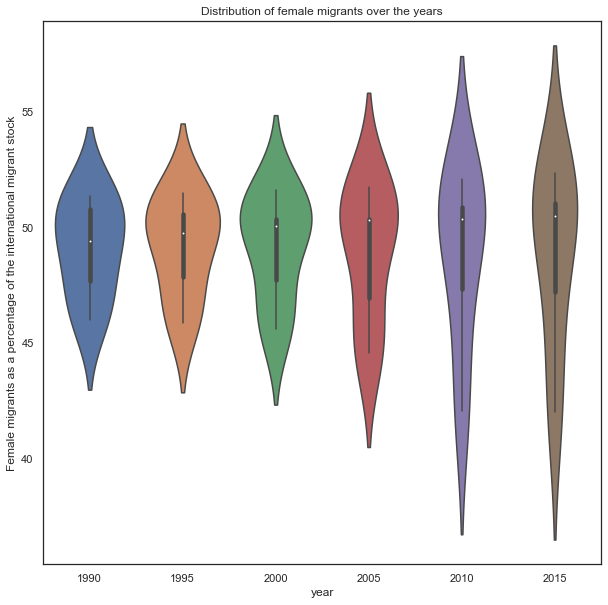

In [212]:
table4_1 = table4[table4[major_col].isin(major_areas)]
# table4_1 = table4_1[table4_1['year'] == 2015]
sns.violinplot(x='year', y=table4_col, data=table4_1)
plt.title('Distribution of female migrants over the years')
plt.show()

# Process Table 5

In [140]:
table5_col = 'Annual rate of change of the migrant stock for last five years'
table5 = pd.read_excel(excel_name, sheet_name="Table 5", header=15)
table5 = update_tables(table5, table5_col, True)
table5.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3975 entries, 0 to 1324
Data columns (total 5 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   Country code                                                    3975 non-null   int32  
 1   Major area, region, country or area of destination              3975 non-null   string 
 2   period                                                          3975 non-null   string 
 3   Annual rate of change of the migrant stock for last five years  3930 non-null   float64
 4   gender                                                          3975 non-null   string 
dtypes: float64(1), int32(1), string(3)
memory usage: 170.8 KB


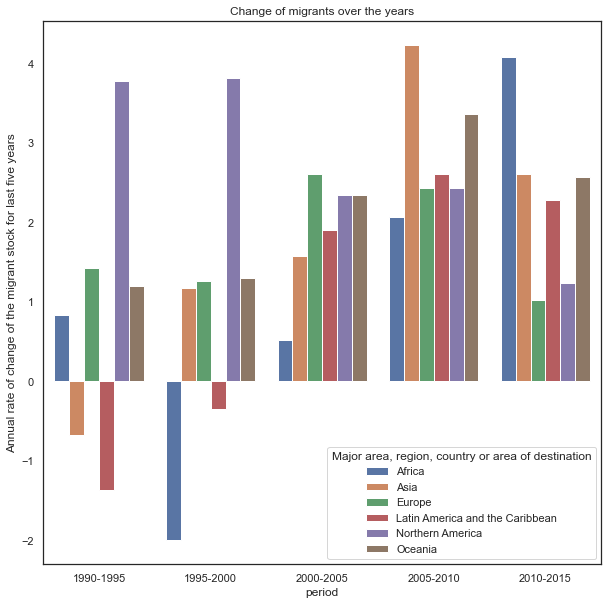

In [210]:
table5_1 = table5[table5['gender'] == 'both sexes']
table5_1 = table5_1[table5_1[major_col].isin(major_areas)]
table5_1 = table5_1[['period', major_col, table5_col]]
sns.barplot(y=table5_col, x='period', data=table5_1, hue=major_col)
plt.title('Change of migrants over the years')
plt.show()

# Process table 6

In [26]:
table6 = pd.read_excel(excel_name, sheet_name="Table 6", header=15)
table6.columns

Index([ 'Unnamed: 0',  'Unnamed: 1',  'Unnamed: 2',  'Unnamed: 3',
        'Unnamed: 4',          1990,          1995,          2000,
                2005,          2010,          2015,      '1990.1',
            '1995.1',      '2000.1',      '2005.1',      '2010.1',
            '2015.1',   '1990-1995',   '1995-2000',   '2000-2005',
         '2005-2010',   '2010-2015', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27',
       'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31'],
      dtype='object')

In [27]:
# First sub-table for "Estimated refugee stock at mid-year"
table6_1_col = 'Estimated refugee stock at mid-year'
table6_1 = update_one_table(table6, table6_1_col, 'both sexes')
table6_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1590 entries, 0 to 1589
Data columns (total 5 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Country code                                        1590 non-null   int32  
 1   Major area, region, country or area of destination  1590 non-null   string 
 2   year                                                1590 non-null   int32  
 3   Estimated refugee stock at mid-year                 1579 non-null   float64
 4   gender                                              1590 non-null   string 
dtypes: float64(1), int32(2), string(2)
memory usage: 49.8 KB


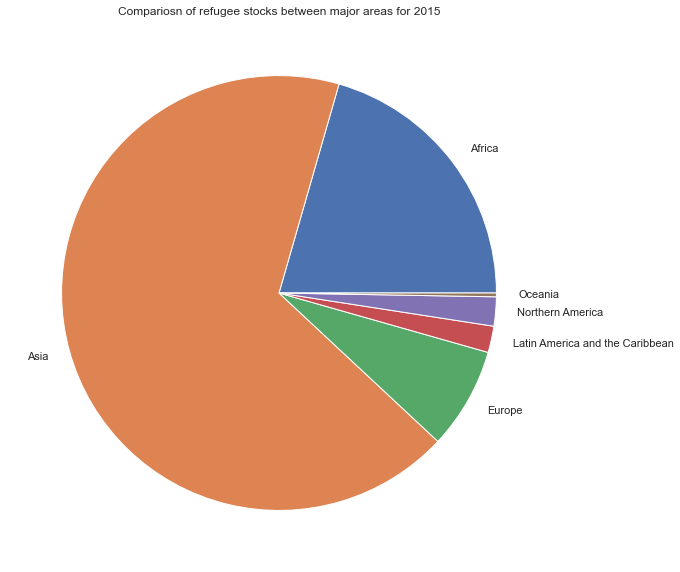

In [28]:
table6_1_1 = table6_1[table6_1[major_col].isin(major_areas)]
table6_1_1 = table6_1_1[table6_1_1['year'] == 2015]

plt.pie(table6_1_1[table6_1_col].values, labels=table6_1_1[major_col].values)
plt.title('Compariosn of refugee stocks between major areas for 2015')
plt.show()


In [29]:
table6_2_col = 'Refugees as a percentage of the international migrant stock'
table6_2 = update_one_table(table6, table6_2_col, 'both sexes', False, '.1')
table6_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1590 entries, 0 to 1589
Data columns (total 5 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Country code                                                 1590 non-null   int32  
 1   Major area, region, country or area of destination           1590 non-null   string 
 2   year                                                         1590 non-null   int32  
 3   Refugees as a percentage of the international migrant stock  1575 non-null   float64
 4   gender                                                       1590 non-null   string 
dtypes: float64(1), int32(2), string(2)
memory usage: 49.8 KB


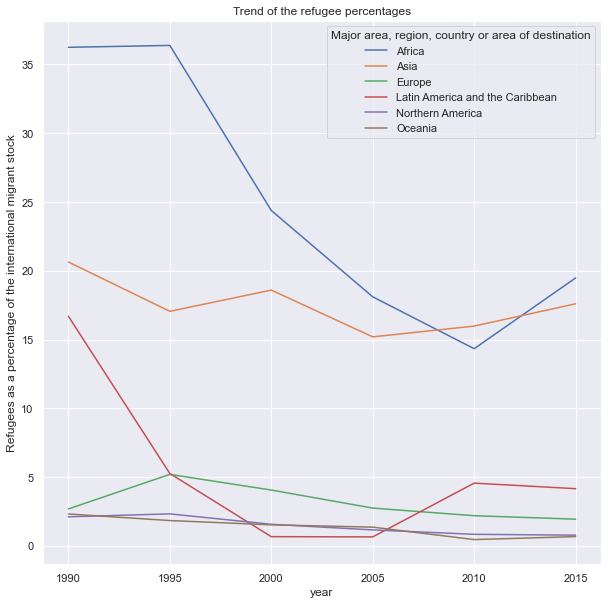

In [30]:
table6_2_1 = table6_2[table6_2[major_col].isin(major_areas)]
sns.lineplot(y=table6_2_col, x="year", hue=major_col, data=table6_2_1)
plt.title('Trend of the refugee percentages')
plt.show()

In [32]:
table6_3_col = 'Annual rate of change of the refugee stock for last five years'
table6_3 = update_one_table(table6, table6_3_col, 'both sexes', True)
table6_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1325 entries, 0 to 1324
Data columns (total 5 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   Country code                                                    1325 non-null   int32  
 1   Major area, region, country or area of destination              1325 non-null   string 
 2   period                                                          1325 non-null   string 
 3   Annual rate of change of the refugee stock for last five years  890 non-null    float64
 4   gender                                                          1325 non-null   string 
dtypes: float64(1), int32(1), string(3)
memory usage: 46.7 KB


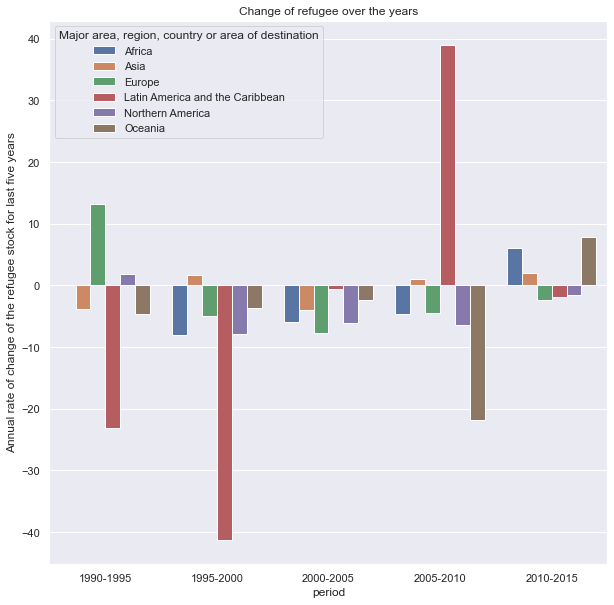

In [33]:
table6_3_1 = table6_3[table6_3[major_col].isin(major_areas)]
sns.barplot(y=table6_3_col, x="period", hue=major_col, data=table6_3_1)
plt.title('Change of refugee over the years')
plt.show()